# Extract geographical watershed properties

Hydrological model typically need geographical information about watersheds being simulated: latitude and longitude, area, mean altitude, land-use, etc. This notebook shows how to obtain this information using remote services. These services connect to a digital elevation model (DEM) and a land-use data set to extract relevant information.

The DEM used in the following is the [EarthEnv-DEM90](https://www.earthenv.org/DEM), while the land-use dataset is the [North American Land Change Monitoring System](http://www.cec.org/tools-and-resources/north-american-environmental-atlas/north-american-land-change-monitoring-system). Other data sources could be used, given their availability through the Web Coverage Service (WCS) protocol.


In [1]:
import json
import os
from zipfile import ZipFile

from birdy import WPSClient
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy
import rasterio
import rioxarray as rio
import xarray as xr

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)

# Connect to the PAVICS-Hydro Raven WPS server
wps = WPSClient(url)

## Watershed contour

We first extract the watershed contour for the point of interest. The process looks into the HydroSheds database to finds the watershed enclosing the given location. The `location` parameter identifies the outlet of the watershed, and `aggregate_upstream` determines whether or not we want the service to return the union of all upstream basins. Here we set it to `False` to reduce the size of the basin and speed-up computations.

The output of the `hydrosheds-select` process is a GeoJSON file.

In [2]:
select_resp = wps.hydrobasins_select(
    location="-71.291660, 50.492758", aggregate_upstream=False
)

In [3]:
# Get GeoJSON polygon of the delineated catchment.
# We can either get links to the files stored on the server, or get the data directly.
# This requires updated Birdy with geojson converters
feature_url, upstream_basins_url = select_resp.get(asobj=False)
feature, upstream_basins = select_resp.get(asobj=True)

We can now plot the outline of the watershed by loading it into `GeoPandas`.

,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,LAKE,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SIDE,SORT,SUB_AREA,UP_AREA,id,geometry
0,0,490.9,490.9,0,7120270182,0,7120034330,7120270181,7120034330,1,724089370000,R,96929,29,9419.6,USGS_HydroBASINS_lake_na_lev12.96929,"MULTIPOLYGON (((-71.35920 50.41960, -71.36210 ..."


<AxesSubplot:>

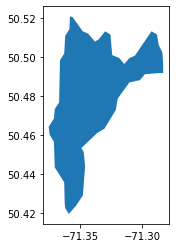

In [4]:
df = gpd.read_file(feature_url)
display(df)
df.plot()

## Generic watershed properties

Now that we have delineated a watershed, lets find the zonal statistics and other properties using the `shape_properties` process. This process requires a `shape` argument defining the watershed contour, the exterior polygon. The polygon can be given either as a link to a geometry file  (e.g. a geojson file such as `feature_url`), or as data embeded in a string. For example, if variable `feature` is a geopandas geometry, `json.dumps(feature)` can be used to convert it to a string and pass it as the `shape` argument.

In [5]:
shape_resp = wps.shape_properties(shape=feature_url)

Once the process has completed, we extract the data from the response:

In [6]:
[
    properties,
] = shape_resp.get(asobj=True)
prop = properties[0]
display(prop)

area = prop["area"] / 1000000.0
longitude = prop["centroid"][0]
latitude = prop["centroid"][1]
gravelius = prop["gravelius"]
perimeter = prop["perimeter"]

shape_info = {
    "area": area,
    "longitude": longitude,
    "latitude": latitude,
    "gravelius": gravelius,
    "perimeter": perimeter,
}
display(shape_info)

{'id': 'USGS_HydroBASINS_lake_na_lev12.96929',
 'COAST': 0,
 'DIST_MAIN': 490.9,
 'DIST_SINK': 490.9,
 'ENDO': 0,
 'HYBAS_ID': 7120270182,
 'LAKE': 0,
 'MAIN_BAS': 7120034330,
 'NEXT_DOWN': 7120270181,
 'NEXT_SINK': 7120034330,
 'ORDER': 1,
 'PFAF_ID': 724089370000,
 'SIDE': 'R',
 'SORT': 96929,
 'SUB_AREA': 29,
 'UP_AREA': 9419.6,
 'area': 28764841.28349778,
 'centroid': [-71.3409808346398, 50.478880424555875],
 'perimeter': 33017.421967875554,
 'gravelius': 1.736629751937897}

{'area': 28.76484128349778,
 'longitude': -71.3409808346398,
 'latitude': 50.478880424555875,
 'gravelius': 1.736629751937897,
 'perimeter': 33017.421967875554}

Note that these properties are a mix of the properties of the original file where the shape is stored, and properties computed by the process (area, centroid, perimeter and gravelius). Note also that the computed area is in m², while the "SUB_AREA" property is in km², and that there are slight differences between the two values.

## Land-use information

Now we extract the land-use properties of the watershed using the `nalcms_zonal_stats` process. As mentionned, it uses the [North American Land Change Monitoring System](http://www.cec.org/tools-and-resources/north-american-environmental-atlas/north-american-land-change-monitoring-system) dataset, and retrieve properties over the given region.

With the `nalcms_zonal_stats_raster` process, we also return the grid with variable accessors (`gdal`, `rasterio`, or `rioxarray`) depending on what libraries are available in our runtime environment (The following examples show `rioxarray`-like access).

In [7]:
stats_resp = wps.nalcms_zonal_stats_raster(
    shape=feature_url, select_all_touching=True, band=1, simple_categories=True
)

Metalink content-type detected.


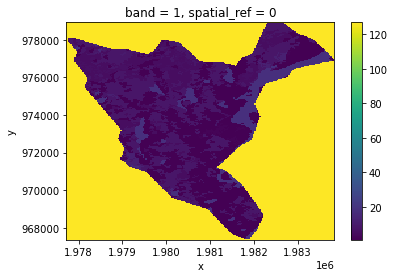

In [8]:
# Note that geojson, and rasterio/rioxarray need to be installed for this to work.
# In the next birdy release, the tiff grid will be automatically converted to a DataArray.
# Here we need to manually convert it.
features, statistics, grid = stats_resp.get(asobj=True)

with rasterio.io.MemoryFile(grid[0]) as memfile:
    with memfile.open() as dataset:
        grid = rio.open_rasterio(dataset)

grid.plot()

From there, it's easy to calculate the ratio and percentages of each land-use component.

In [9]:
lu = statistics[0]
total = sum(lu.values())

land_use = {k: (v / total) for (k, v) in lu.items()}
display("Land use ratios", land_use)

precision = 2
land_use_pct = {
    k: "{} %".format(int((v / total) * 100 * 10 ** precision) / 10 ** precision)
    for (k, v) in lu.items()
}
display("Land use percentages", land_use_pct)

'Land use ratios'

{'Ocean': 0.0,
 'Forest': 0.5770231039071005,
 'Shrubs': 0.3096346921495101,
 'Grass': 0.014485303011975323,
 'Wetland': 0.0006350550381033022,
 'Crops': 0.0,
 'Urban': 0.0,
 'Water': 0.09822184589331075,
 'SnowIce': 0.0}

'Land use percentages'

{'Ocean': '0.0 %',
 'Forest': '57.7 %',
 'Shrubs': '30.96 %',
 'Grass': '1.44 %',
 'Wetland': '0.06 %',
 'Crops': '0.0 %',
 'Urban': '0.0 %',
 'Water': '9.82 %',
 'SnowIce': '0.0 %'}

In [10]:
grid

<xarray.DataArray (band: 1, y: 385, x: 204)>
array([[[127, 127, ..., 127, 127],
        [127, 127, ..., 127, 127],
        ...,
        [127, 127, ..., 127, 127],
        [127, 127, ..., 127, 127]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 9.789e+05 9.789e+05 ... 9.674e+05 9.674e+05
  * x            (x) float64 1.978e+06 1.978e+06 ... 1.984e+06 1.984e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    127.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

array([  1,   2,   5,   6,   8,  10,  12,  14,  16,  18, 127], dtype=uint8)

array([13532,   335,  4367,   847, 10239,    60,   380,    21,    39,
        3248, 45472])

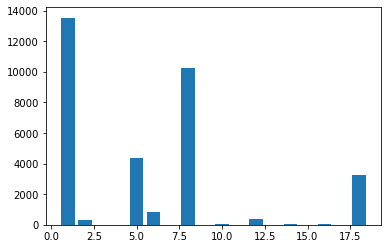

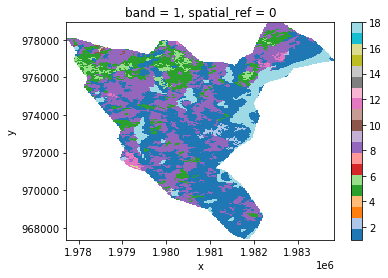

In [11]:
unique, counts = numpy.unique(grid.sel(band=1), return_counts=True)
display(unique, counts)

# Pixels values at '127' are NaN and can be ignored.
plt.bar(unique[:-1], counts[:-1])
plt.show()

grid.where(grid != 127).sel(band=1).plot.imshow(cmap="tab20")
plt.show()

With `rioxarray` and `cartopy` (and `birdy>0.7.0`) installed, we can receive the geotiff object as an `xarray.Dataset` with the `.open_rasterio()` method. This makes it very easy to spatially reproject it with the `cartopy` library.

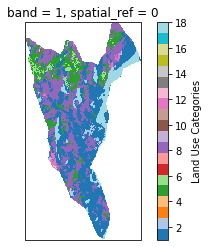

In [12]:
import cartopy.crs as ccrs

# Set a CRS transformation:
crs = ccrs.LambertConformal(
    central_latitude=49, central_longitude=-95, standard_parallels=(49, 77)
)

ax = plt.subplot(projection=crs)
grid.name = "Land Use Categories"
grid.where(grid != 127).sel(band=1).plot.imshow(ax=ax, transform=crs, cmap="tab20")
plt.show()

## Terrain information from the DEM

Here we collect terrain data, such as elevation, slope and aspect, from the DEM. We will do this using the `terrain_analysis` WPS service, which by default uses DEM data from [EarthEnv-DEM90](https://www.earthenv.org/DEM).

Note here that while the feature outline is defined above in terms of geographic coordinates (latitude, longitude), the DEM is projected onto a 2D cartesian coordinate system (here NAD83, the Canada Atlas Lambert projection). This is necessary to perform slope calculations. For more information on this, see: https://en.wikipedia.org/wiki/Map_projection

The DEM data returned in the process response here shows `rioxarray`-like access but using the URLs we can open the files however we like.

In [13]:
terrain_resp = wps.terrain_analysis(
    shape=feature_url, select_all_touching=True, projected_crs=3978
)

In [14]:
properties, dem = terrain_resp.get(asobj=True)

with rasterio.io.MemoryFile(dem) as memfile:
    with memfile.open() as dataset:
        dem = rio.open_rasterio(dataset)

elevation = properties[0]["elevation"]
slope = properties[0]["slope"]
aspect = properties[0]["aspect"]

terrain = {"elevation": elevation, "slope": slope, "aspect": aspect}
display(terrain)

{'elevation': 490.04395604395603,
 'slope': 3.9660650465635636,
 'aspect': 116.79663053081183}

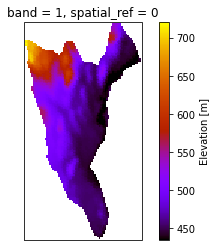

In [15]:
crs = ccrs.LambertConformal(
    central_latitude=49, central_longitude=-95, standard_parallels=(49, 77)
)

dem.name = "Elevation"
dem.attrs["units"] = "m"
ax = plt.subplot(projection=crs)
dem.where(dem != -32768).sel(band=1).plot.imshow(ax=ax, transform=crs, cmap="gnuplot")
plt.show()

In [16]:
# We can also access the files directly via their URLs:
properties, dem = terrain_resp.get(asobj=False)
display(properties, dem)

# Let's read the data from band=1 as numpy array
display(rasterio.open(dem).read(1))

'https://pavics.ouranos.ca/wpsoutputs/1d16d622-9d8a-11eb-8610-3417ebcfda20/input.json'

'https://pavics.ouranos.ca/wpsoutputs/1d16d622-9d8a-11eb-8610-3417ebcfda20/clipped_hhw_8ldi.tiff'

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

## Overview

A synthesis of all watershed properties can be created by merging the various dictionaries created.

In [17]:
all_properties = {**shape_info, **land_use, **terrain}
display(all_properties)

{'area': 28.76484128349778,
 'longitude': -71.3409808346398,
 'latitude': 50.478880424555875,
 'gravelius': 1.736629751937897,
 'perimeter': 33017.421967875554,
 'Ocean': 0.0,
 'Forest': 0.5770231039071005,
 'Shrubs': 0.3096346921495101,
 'Grass': 0.014485303011975323,
 'Wetland': 0.0006350550381033022,
 'Crops': 0.0,
 'Urban': 0.0,
 'Water': 0.09822184589331075,
 'SnowIce': 0.0,
 'elevation': 490.04395604395603,
 'slope': 3.9660650465635636,
 'aspect': 116.79663053081183}